In [1]:
import pickle
import gym
import pandas as pd
import torch as th
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv

In [2]:
file_path = './final_ipynb/'

In [3]:
# Retrieve the train and set data
x_train_df, y_train_df = pd.read_csv(file_path+'x_train.csv'), pd.read_csv(file_path+'y_train.csv')
x_test_df, y_test_df = pd.read_csv(file_path+'x_test.csv'), pd.read_csv(file_path+'y_test.csv')

In [4]:
# Save the name of the columns for XAI
pickle.dump(x_train_df.columns.values, open(file_path+'transformed_columns.pkl', 'wb'))

# Transform dataframe to numpy arrays for RL model
x_train, y_train = x_train_df.values, y_train_df.values.flatten()
x_test, y_test = x_test_df.values, y_test_df.values.flatten()

# Delete original dataframe to save memory
del x_train_df, y_train_df, x_test_df, y_test_df

In [5]:
rw_factor = compute_class_weight(class_weight='balanced',
                                     classes=[0, 1],
                                     y=y_train)

minority_classes = [1]

In [6]:
class TrainEnv(gym.Env):
    def __init__(self, dataset=(x_train, y_train), rw_factor=rw_factor, minority_classes=minority_classes):
        
        super().__init__()

        self.x, self.y = dataset
        self.rw_factor = rw_factor
        self.idx = random.randint(0, len(self.x) - 1)
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=-1000, high=1000,
                                                shape=(self.x.shape[1], ),
                                                dtype=np.float32)
        
        self.minority_classes = minority_classes
        self.step_counter = 0
        self.max_steps = len(self.x)

    def step(self, action):
        done = False
        
        # Reward management
        if int(action == self.expected_action):
            reward = self.rw_factor[self.expected_action]
        else:
            reward = -self.rw_factor[self.expected_action]
            if self.expected_action in self.minority_classes:
                done = True

        # Observation management
        self.idx += 1
        if self.idx >= len(self.x):
            self.idx = 0
        obs = self.seq_observation()

        # Done management 2 -> If a whole sweep of X is achieved
        self.step_counter += 1
        if self.step_counter >= self.max_steps:
            done = True
        
        return obs, reward, done, {}

    def reset(self):
        # Start from failed idx
        self.step_counter = 0
        obs = self.seq_observation()
        return obs
    
    def seq_observation(self):        
        obs = self.x[self.idx]
        self.expected_action = self.y[self.idx]
        return obs

In [7]:
class SaveBest(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 0):
        super(SaveBest, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'Models/PPO')        
        self.max_score = -np.inf
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            current_score = self.compute_acc()
            diff = current_score - self.max_score
            
            if diff > 0.001:
                self.max_score = current_score
                print(f'New best score at {self.num_timesteps}')
                print(f'F1: {self.max_score}')
                print('----- ----- -----')
                self.model.save(self.save_path)

        return True
    
    def compute_acc(self) -> float:
        y_test_pred, _ = self.model.predict(x_test, deterministic=True)
        current_score = metrics.f1_score(y_test, y_test_pred)
        return current_score

In [8]:
def make_env(rank, seed=0):
    def _init():
        env = TrainEnv()
        env = Monitor(env, './')
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

In [9]:
n_parallel_env = 10
train_env = SubprocVecEnv([make_env(i) for i in range(n_parallel_env)])
# train_env = TrainEnv()
train_env.reset()
print(':)')

:)


In [10]:
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[64, 64], vf=[64, 64]))


model = PPO(policy='MlpPolicy',
            env=train_env,
            policy_kwargs=policy_kwargs)

In [11]:
TIMESTEPS = len(x_train)
callback = SaveBest(check_freq=10, log_dir='./')

model.learn(total_timesteps=TIMESTEPS,
            reset_num_timesteps=False,
            progress_bar=True,
            callback=callback)

Output()

New best score at 1000

F1: 0.33412560115921885

----- ----- -----

New best score at 21000

F1: 0.9421129762856382

----- ----- -----

New best score at 62000

F1: 0.9452380838814614

----- ----- -----

New best score at 1823000

F1: 0.9463271573979872

----- ----- -----

In [12]:
# model.save('PPO')
model = PPO.load('./Models/PPO')

In [13]:
y_pred, _ = model.predict(x_test, deterministic=True)

In [14]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred):
    # Macro-avg is recommended to keep minority classes relevant
    # Weighted-avg is recommended to keep majority classes relevant
    print(f'Metrics')
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, zero_division=0)
    pre = metrics.precision_score(y_truth, y_pred, zero_division=0)
    f1s = metrics.f1_score(y_truth, y_pred, zero_division=0)

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.3f')

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

Metrics


Accuracy     0.977880
Recall       0.999627
Precision    0.898424
F1-score     0.946327
Name: PPO, dtype: float64

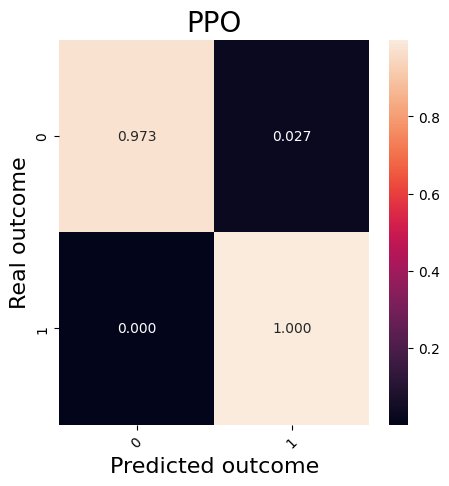

In [15]:
getMetrics('PPO', y_test, y_pred)
getCM('PPO', y_test, y_pred)